# 18.065 project: comparison result

In [1]:
#import sys
#!{sys.executable} -m pip install tf-nightly

In [2]:
# Autoencoder imports
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Kernel PCA imports
import numpy as np
import os
import sys
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.datasets import make_swiss_roll
from sklearn.metrics import mean_squared_error
import math

In [4]:
# more readable visuals 
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.style.use('seaborn-white')
plt.rcParams.update(params)
%matplotlib inline

/var/folders/_1/ph90y1r548z0kmxwq40w_3y80000gn/T/ipykernel_4418/2071146880.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## Iris dataset: Sparse PCA, Kernel PCA, autoencoder, NMF (TODO); MSE, Frobenius (TODO)

In [5]:
# load Iris dataset
iris = load_iris()
X = iris.data # predictor
y = iris.target #response

print('The predictor variable shape: ', X.shape)
print('The response variable shape: ', y.shape)

# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

The predictor variable shape:  (150, 4)
The response variable shape:  (150,)


### Sparse PCA + Iris + MSE

In [6]:
# Experiment parameters

k=2 # Number of principal components

In [7]:
# TODO: hyperparameter search

#SparsePCA(n_components=k, alpha=1, ridge_alpha=0.01, max_iter=1000, tol=1e-08, method='lars', n_jobs=1, U_init=None, V_init=None, verbose=False, random_state=None)

def spca_exp(X_scaled,k):
    alpha_vals=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.10, 0.20, 0.50, 1.0, 2.0, 5.0]
    ridge_alpha=0.0

    best_spca_alpha=0.0
    best_spca_alpha_err=math.inf
    for idx in range(len(alpha_vals)):
        alpha=alpha_vals[idx]
        spca = SparsePCA(n_components=k, ridge_alpha=ridge_alpha, alpha=alpha)
        spca.fit(X_scaled)
        V=spca.components_.transpose()
        Z=spca.transform(X_scaled)
        X_preimage=Z @ V.transpose()
        spca_err=mean_squared_error(X_scaled, X_preimage)
        print("alpha=",alpha,"err=",spca_err)
        if spca_err < best_spca_alpha_err:
            best_spca_alpha_err=spca_err
            best_spca_alpha=alpha

    print("\n\nBest SPCA:")
    print("- alpha:",best_spca_alpha)
    print("- err:",best_spca_alpha_err)
    
    return best_spca_alpha, best_spca_alpha_err



In [8]:
best_spca_alpha, best_spca_alpha_err = spca_exp(X_scaled,k)

alpha= 0.001 err= 0.2043732558490774
alpha= 0.002 err= 0.20437326545542334
alpha= 0.005 err= 0.20437335355328623
alpha= 0.01 err= 0.2043736831651194
alpha= 0.02 err= 0.20437508533290538
alpha= 0.05 err= 0.20438454406514173
alpha= 0.1 err= 0.2044170150945047
alpha= 0.2 err= 0.2045506684800743
alpha= 0.5 err= 0.2054457247487394
alpha= 1.0 err= 0.20569756539961365
alpha= 2.0 err= 0.20916797925025438
alpha= 5.0 err= 0.2701620810923319


Best SPCA:
- alpha: 0.001
- err: 0.2043732558490774


### Kernel PCA + Iris + MSE

In [9]:
#kpca_rbf = KernelPCA(n_components = k, kernel="rbf", gamma=0.04) #todo: choice of gamma? choice of kernel? Sweep?
#kpca_rbf = kpca_rbf.fit_transform(X_scaled)

In [10]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section
# TODO: hyperparameter sweep for kernel, gamma, coef0, other attributes

from sklearn.decomposition import KernelPCA
import math

def kernel_exp(X_scaled,k):

    lin_pca = KernelPCA(n_components = k, kernel="linear", fit_inverse_transform=True)
    rbf_pca = KernelPCA(n_components = k, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
    sig_pca = KernelPCA(n_components = k, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

    kernel_options=((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$"))

    best_kernel=""
    best_kernel_err=math.inf
    for subplot, pca, title in kernel_options:
        X_reduced = pca.fit_transform(X_scaled)
        X_preimage = pca.inverse_transform(X_reduced)
        err=mean_squared_error(X_scaled, X_preimage)
        print("Kernel PCA (",title,") MSE reconstruction loss:",err)
        if err < best_kernel_err:
            best_kernel=title
            best_kernel_err=err
            print("- New best kernel")

    print("\n\nBest MSE reconstruction error:",best_kernel_err)
    print("- Kernel:",best_kernel)
    
    return best_kernel, best_kernel_err

In [11]:
best_kernel, best_kernel_err = kernel_exp(X_scaled,k)

Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.2046553027769746
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.04727377268500417
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 0.06862464338168228


Best MSE reconstruction error: 0.04727377268500417
- Kernel: RBF kernel, $\gamma=0.04$


### Autoencoder + Iris + MSE

In [12]:
def plot3clusters(X, title, vtitle, target_names):
    colors = ['#A43F98', '#5358E0', '#DE0202']
    s = 50
    alpha = 0.7
    
    plt.figure(figsize=(9, 7))
    plt.grid(True)
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=alpha, s=s, label=target_name)
   
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title, fontsize=16, fontweight='bold')
    
    plt.text(0.5, -0.1, 'Principal Component 1', ha='center', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(-0.1, 0.5, 'Principal Component 2', va='center', rotation='vertical', fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    
    plt.show()  

def autoencoder_exp(X_scaled, k):
    input_dim = X_scaled.shape[1] #input shape
    output_dim = X_scaled.shape[1]
    encoding_dim = k # encoding dimension - #neurons for the dense layers
    optimizer = 'adam'
    loss = 'mse'

    input_layer = tf.keras.Input(shape=(input_dim,), name='input') # input layer
    encoding_layer = tf.keras.layers.Dense(encoding_dim, name='encoding')(input_layer) # encoding layer
    decoding_layer = tf.keras.layers.Dense(output_dim, name='decoding')(encoding_layer) # decoding layer

    autoencoder = tf.keras.Model(input_layer, decoding_layer)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    
    # Set other parameters
    epochs=50
    batch_size=16
    shuffle=True
    validation_split=0.1
    verbose=0

    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

    history = autoencoder.fit(X_scaled, X_scaled,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=shuffle,
                              validation_split=validation_split,
                              verbose=verbose)
    #                           callbacks=[early_stop])

    # Plot the loss 
    plt.plot(history.history['loss'], color='#FF7E79',linewidth=3, alpha=0.5)
    plt.plot(history.history['val_loss'], color='#007D66', linewidth=3, alpha=0.4)
    plt.title('Model train vs Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid(True)
    plt.show()    
    
    print("Training loss:", history.history['loss'][-1])
    print("Validation loss:", history.history['val_loss'][-1])    
    
    if k==2: # can only plot if there are 2dims
        encoder = tf.keras.Model(input_layer, encoding_layer)
        encoded_data = encoder.predict(X_scaled)

        target_names = iris.target_names

        #plot3clusters(encoded_data, 'Encoded data latent-space', 'dimension ', target_names);  
        
    autoencoder_err=mean_squared_error(X_scaled, autoencoder(X_scaled))
    print("MSE=",autoencoder_err)
    
    return None, autoencoder_err

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 encoding (Dense)            (None, 2)                 10        
                                                                 
 decoding (Dense)            (None, 4)                 12        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


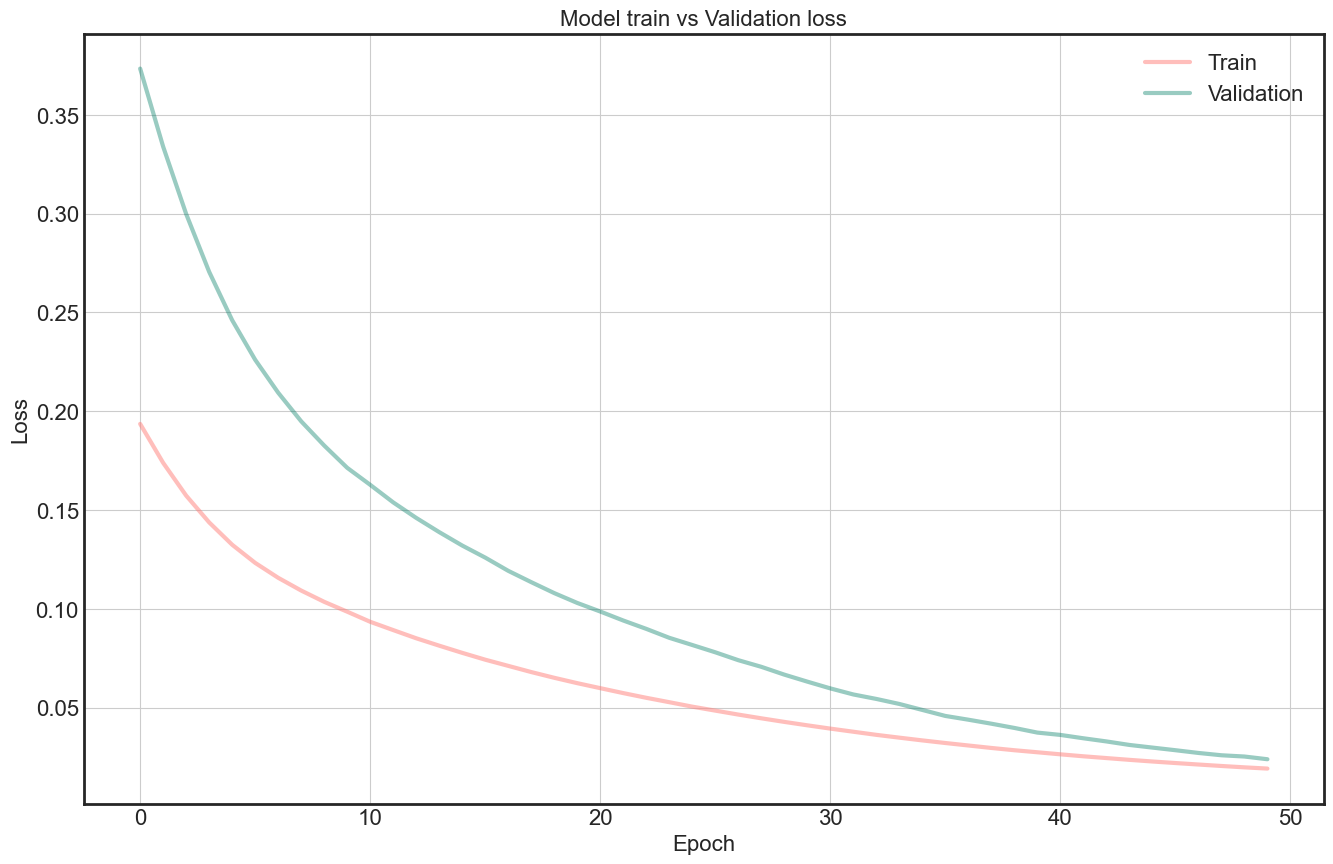

Training loss: 0.019119683653116226
Validation loss: 0.023848336189985275
5/5 [==============================] - 0s 416us/step
MSE= 0.019215729059137553


In [13]:
_,best_autoencoder_err = autoencoder_exp(X_scaled, k)

### NMF + iris + MSE - TODO

In [14]:
# TODO

## Iris + MSE summary

In [15]:
print("Summary, Iris + MSE:")
print("- k=",k)
print("- Sparse PCA (alpha=",best_spca_alpha,"): err=",best_spca_alpha_err)
print("- Kernel PCA(",best_kernel,"): err=",best_kernel_err)
print("- Autoencoder: err=",best_autoencoder_err)

Summary, Iris + MSE:
- k= 2
- Sparse PCA (alpha= 0.001 ): err= 0.2043732558490774
- Kernel PCA( RBF kernel, $\gamma=0.04$ ): err= 0.04727377268500417
- Autoencoder: err= 0.019215729059137553


## Swiss roll dataset: Sparse PCA, Kernel PCA, autoencoder

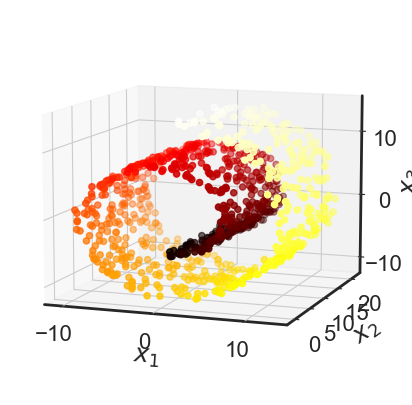

In [16]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

### Sparse PCA + Swiss roll + MSE

In [17]:
best_spca_alpha, best_spca_alpha_err = spca_exp(X_scaled,k)

alpha= 0.001 err= 0.26513643947566085
alpha= 0.002 err= 0.26513644058542096
alpha= 0.005 err= 0.2651365103810612
alpha= 0.01 err= 0.2651366454636503
alpha= 0.02 err= 0.26513723026000896
alpha= 0.05 err= 0.2651413150389939
alpha= 0.1 err= 0.26515521208939813
alpha= 0.2 err= 0.265160565011842
alpha= 0.5 err= 0.26521728654556304
alpha= 1.0 err= 0.26584738514197714
alpha= 2.0 err= 0.2673244098018101
alpha= 5.0 err= 0.2673244098018101


Best SPCA:
- alpha: 0.001
- err: 0.26513643947566085


### Kernel PCA + Swiss roll + MSE

In [18]:
best_kernel, best_kernel_err=kernel_exp(X_scaled,k)

Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.26514402865615555
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.04339327856746578
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 0.07919834691603612


Best MSE reconstruction error: 0.04339327856746578
- Kernel: RBF kernel, $\gamma=0.04$


### Autoencoder + Swiss roll + MSE

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 encoding (Dense)            (None, 2)                 8         
                                                                 
 decoding (Dense)            (None, 3)                 9         
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


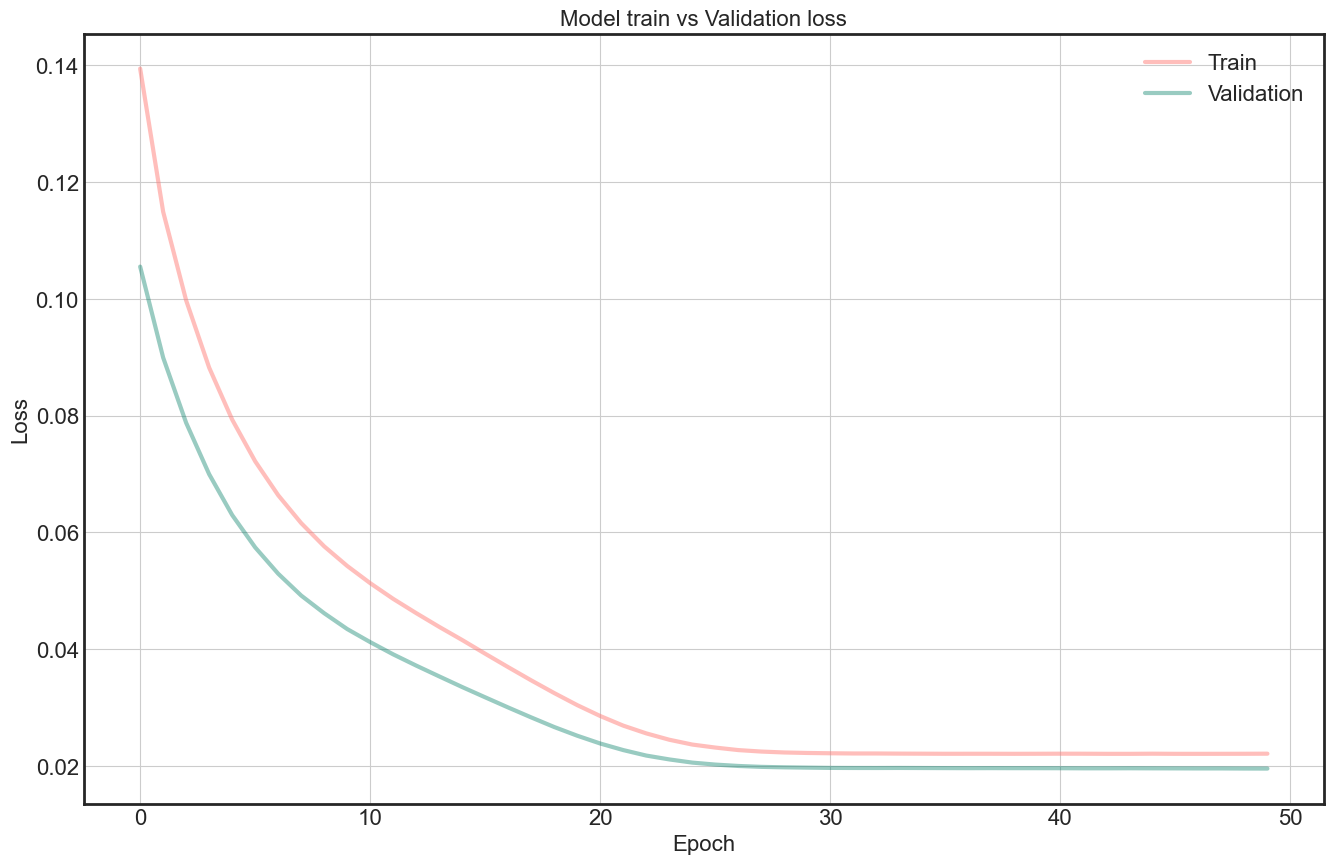

Training loss: 0.0221138596534729
Validation loss: 0.019561858847737312
32/32 [==============================] - 0s 298us/step
MSE= 0.021814188064025703


In [19]:
_,best_autoencoder_err = autoencoder_exp(X_scaled, k)

## Swiss roll + MSE summary

In [20]:
print("Summary, Swiss roll + MSE:")
print("- k=",k)
print("- Sparse PCA (alpha=",best_spca_alpha,"): err=",best_spca_alpha_err)
print("- Kernel PCA(",best_kernel,"): err=",best_kernel_err)
print("- Autoencoder: err=",best_autoencoder_err)

Summary, Swiss roll + MSE:
- k= 2
- Sparse PCA (alpha= 0.001 ): err= 0.26513643947566085
- Kernel PCA( RBF kernel, $\gamma=0.04$ ): err= 0.04339327856746578
- Autoencoder: err= 0.021814188064025703
